## Linear Regression and RANSAC

In [1]:
# Load the modules we need
import numpy as np
from matplotlib import pyplot as plt
from sklearn import linear_model, datasets
from statsmodels import robust
import random
from scipy import stats
import copy

In [2]:
#  Create some intial data
n_samples = 1000

X, y = datasets.make_regression(n_samples=n_samples, n_features=1,
                                      n_informative=1, noise=10,
                                      random_state=0)

In [3]:
# Add some outlier data
np.random.seed(0)
n_outliers = 50
X[:n_outliers] = 3 + 0.5 * np.random.normal(size=(n_outliers, 1))
y[:n_outliers] = -3 + 10 * np.random.normal(size=n_outliers)


In [4]:
# Create some test positions for for the lines we will draw
line_X = np.arange(X.min(), X.max())[:, np.newaxis]

In [5]:
# Class for task 2
class LinearRegression:
    
    def fit(self, X, y):
        self._theta = self.objective_function(X, y)
    
    def predict(self, X):
        predictions = np.multiply(X, self._theta)
        return predictions 
    
    def objective_function(self, X, y):
        return np.dot(np.linalg.inv(np.dot(X.T, X)), np.dot(X.T, y))

In [6]:
# This is the cell you need to replace to complete Task 2.
# Fit line using all data.

lr = LinearRegression()
lr.fit(X, y)
line_y = lr.predict(line_X)

In [7]:
# class for task 3
class RANSACRegressor():
    
    def __init__(self, max_iter=100, residual_threshold=1):
        self.inlier_mask_ = []
        self._max_iter = max_iter
        self.residual_threshold = residual_threshold
        self.opt_slope = 0
        self.opt_intercept = 0
        
    def _line(self, x, slope, intercept):
        return slope * x + intercept
    
    def fit(self, X, y):
        self.residual_threshold = robust.mad(y)
        n_points = X.shape[0]

        n_inliers = 0

        for _ in range(self._max_iter):
            mask = []
            rand_p = np.random.randint(low=0, high=n_points, size=2)
            X_rand = X[rand_p, :].flatten()
            y_rand = y[rand_p]

            slope, intercept, _, _, _ = stats.linregress(X_rand, y_rand)
            y_pred = self._line(X, slope, intercept).flatten()
            residual_error = np.subtract(y_pred, y)
            
            for error in residual_error:
                if np.abs(error) < self.residual_threshold:
                    mask.append(True)
                else:
                    mask.append(False)
                    
            curr_n_inliers = np.sum(mask)

            if curr_n_inliers > n_inliers:
                self.inlier_mask_ = copy.deepcopy(mask)
                self.opt_slope = slope
                self.opt_intercept = intercept
                n_inliers = np.sum(self.inlier_mask_)
    
    def predict(self, line_X):
        slope = self.opt_slope
        intercept = self.opt_intercept
        y_pred = self._line(line_X, slope, intercept)
        
        return y_pred          

In [8]:
# This is the cell you need to replace to complete Task 3.
# Robustly fit linear model with RANSAC algorithm
ransac = RANSACRegressor()
ransac.fit(X, y)

# Predict data of estimated models
line_y_ransac = ransac.predict(line_X)

# Label the if source data is inlier or outlier
inlier_mask = ransac.inlier_mask_
outlier_mask = np.logical_not(inlier_mask)


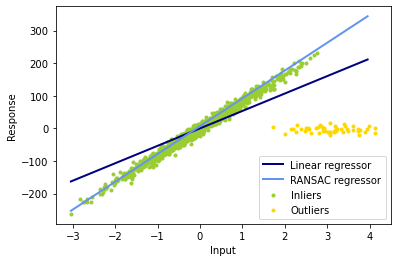

In [9]:
lw = 2

doing_linear = True
doing_ransac = True

if (doing_linear):
    plt.plot(line_X, line_y, color='navy', linewidth=lw, label='Linear regressor')

if (doing_ransac):
    plt.scatter(X[inlier_mask], y[inlier_mask], color='yellowgreen', marker='.', label='Inliers')
    plt.scatter(X[outlier_mask], y[outlier_mask], color='gold', marker='.', label='Outliers')
    plt.plot(line_X, line_y_ransac, color='cornflowerblue', linewidth=lw, label='RANSAC regressor')
else:
    plt.scatter(X, y, color='yellowgreen', marker='.', label='Data')
    
plt.legend(loc='lower right')
plt.xlabel("Input")
plt.ylabel("Response")
plt.show()